<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [13]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

## Подготовка

In [14]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [15]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

**Вывод:**  
Данные загружены, выполнено их ресемплирование по одному часу.

## Анализ

In [16]:
decomposed = seasonal_decompose(data)


<AxesSubplot:xlabel='datetime'>

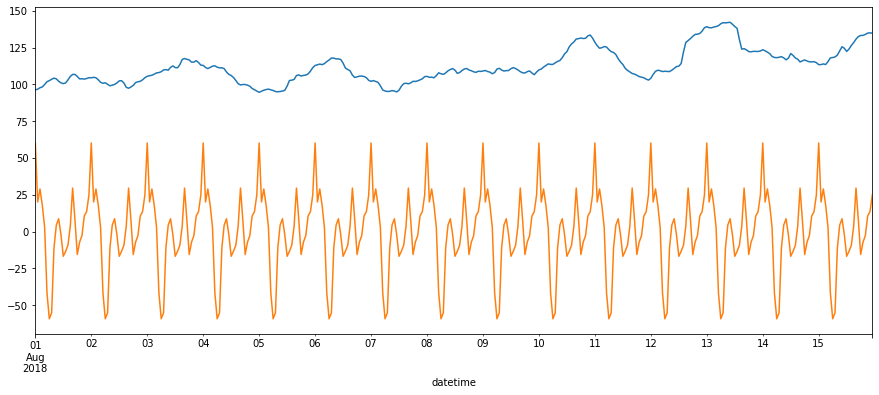

In [17]:
decomposed.trend['2018-08-01':'2018-08-15'].plot()
decomposed.seasonal['2018-08-01':'2018-08-15'].plot(figsize=(15,6))
#decomposed.resid['2018-08-01':'2018-08-15'].plot(figsize=(15,6))

Рассмотрим 

<AxesSubplot:xlabel='datetime'>

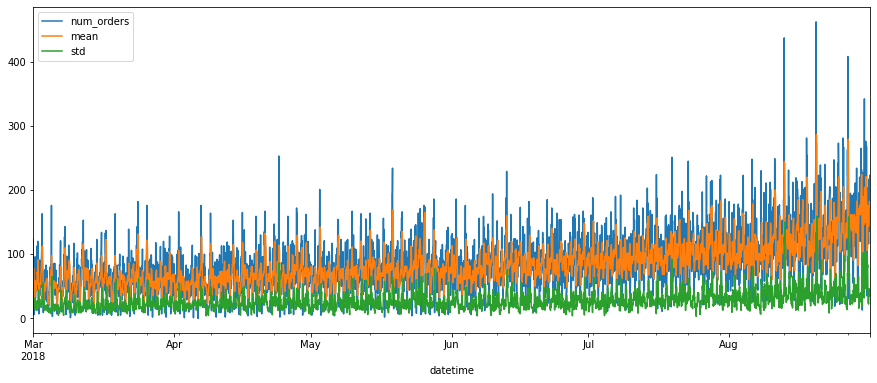

In [18]:
data['mean'] = data['num_orders'].rolling(5).mean()
data['std'] = data['num_orders'].rolling(5).std()
data.plot(figsize=(15,6)) 

<AxesSubplot:xlabel='datetime'>

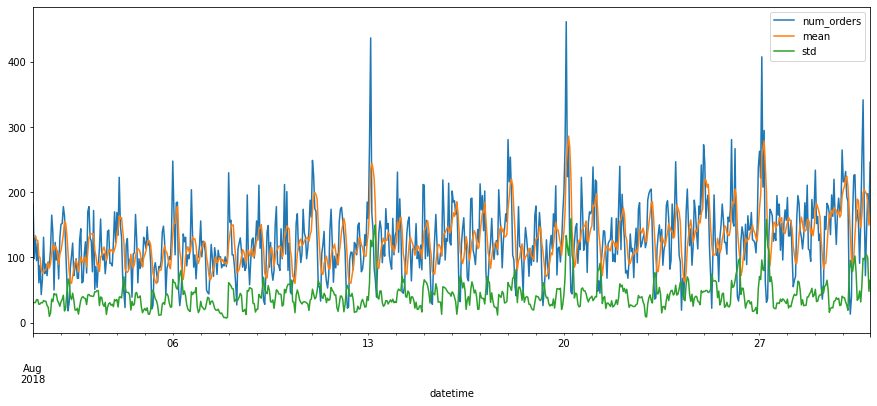

In [19]:
data['2018-08-01':'2018-08-30'].plot(figsize=(15,6))

**Вывод**

Наблюдается рост заказов в летние месяцы(Тренд), а также увеличение заказов в ночные часы, особенно в выходные дни (Сезонность)

## Обучение

Создание дополнитльных признаков

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [21]:
data_new = make_features(data, 8, 5)

In [27]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()

In [26]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [33]:
cv = TimeSeriesSplit()
scoring ='neg_root_mean_squared_error'

**Подбор параметров модель RandomForestRegressor**

In [ ]:
(GridSearchCV(estimator=RandomForestRegressor(), param_grid={'max_depth': [10, 30, 100], 'n_estimators':[100, 500, 1000]}
              ,scoring=scoring, cv=cv).fit(X_train, y_train).best_params_)

In [35]:
model_rfr = RandomForestRegressor(n_estimators=1000, max_depth=30)

In [ ]:
RMSE_rfr = -1*cross_val_score(model_rfr, X_train, y_train, cv=cv, scoring=scoring).mean()
print('RandomForestRegressor:', RMSE_rfr)

**Подбор параметров модель CatBoostRegressor** 

In [ ]:
(GridSearchCV(estimator=CatBoostRegressor(), param_grid={'iterations': [100, 200, 500], 'depth':[10, 20, 30], 'learning_rate':[0.5, 0.2]}
              ,scoring=scoring, cv=cv).fit(X_train, y_train).best_params_)

In [ ]:
model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=500, depth=10, learning_rate=0.2)
RMSE_cbr = -1*cross_val_score(model_cbr, X_train, y_train, cv=cv, scoring=scoring).mean()

In [ ]:
print('RMSE модели CatBoostRegressor:', RMSE_cbr)

**Вывод**  
Подобраны оптимальные параметры для 2-х моделей, достигнуты следующие показатели RMSE на обучающей выборке:
- RandomForestRegressor - 18,23
- CatBoostRegressor - 18,58

## Тестирование

**Тестирование модели RandomForestRegressor()** 

In [36]:
predict_rfr = model_rfr.fit(X_train, y_train).predict(X_test)
RMSE_rfr_test = mean_squared_error(predict_rfr,y_test)**0.5
print('RMSE модель CatBoostRegressor на тестовой выборке:', RMSE_rfr_test)

RMSE модель CatBoostRegressor на тестовой выборке: 41.13007101029875


**Тестирование модели CatBoostRegressor** 

In [ ]:
predict_cbr = model_cbr.fit(X_train, y_train, verbose=100).predict(X_test)
RMSE_cbr_test = mean_squared_error(predict_cbr,y_test)**0.5
print('RMSE модель CatBoostRegressor на тестовой выборке:', RMSE_cbr_test)

**Вывод**  
Были протестированы 2 модели, которые показали на тестовой выборке следующие результаты:
- RMSE модель CatBoostRegressor на тестовой выборке: 41.12016756649749
- RMSE модель CatBoostRegressor на тестовой выборке: 40.34143937321571

Оби модели достигли заданной точности, и могут быть использованы для прогнозировать количество заказов такси на следующий час.


In [53]:
predict = pd.DataFrame(predict_rfr, index=y_test.index, columns=['predict'])

<AxesSubplot:xlabel='datetime'>

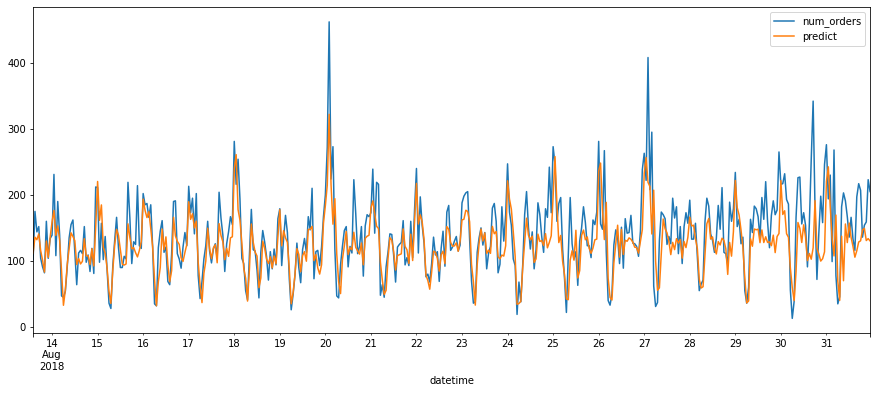

In [54]:
ax = y_test.plot(figsize=(15,6), legend=True)
predict.plot(figsize=(15,6), ax=ax, legend=True)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48